<a href="https://colab.research.google.com/github/amrutur/rl-theory/blob/main/policyopt_1_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Welcome to the first notebook of the NeurIPS 2020 Tutorial on Policy Optimization! This notebook demonstrates the effects of baselines in policy-gradient methods. 
- We start by observing the effect of baselines on the variance of gradients in policy-gradient methods. 
- The second part of the notebook demonstrates that baselines can also affect the entropy of learned policies during optimization.

This first cell sets up the relevant packages for our notebook. Note that this notebook is self-contained — you can run this notebook in your browser without installing anything locally.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys, copy

plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Part I/II: Baselines can reduce variance of updates

For this demonstration, we shall code up REINFORCE agents with and without baselines, and test their performance on a simple 3-armed bandit problem.


### Environment

This cell implements a simple multi-armed bandit problem.

In [ ]:
class MultiArmedBandit:
    """
    A multi-armed bandit problem
    """
    def __init__(self, env_info={}):
        self.num_actions = env_info.get('num_actions', 3)
        self.rewards = env_info.get('rewards', [1,0.7,0])
        assert len(self.rewards) == self.num_actions
        self.rng = np.random.RandomState(env_info.get('random_seed', 42))
        self.rewards_std = env_info.get('rewards_std', [0,0,0])     # adds optional stochasticity in rewards
        
    def step(self, action):
        """
        Args:
            action: the arm pulled
        Returns:
            reward: reward corresponding to that arm
        """
        reward = self.rng.normal(self.rewards[action], self.rewards_std[action], 1)
        return reward


### Agent

We shall now code up the Gradient Bandit algorithm, which updates the policy parameters $\theta$ as:

$$\theta = \theta + \alpha\,(R - b) \nabla_\theta \log \pi_\theta, $$

where $R$ is the reward obtained, $b$ is the baseline, $\alpha$ is the step-size parameter, and $\pi_\theta$ denotes the policy parameterized by $\theta$. We shall use a softmax policy given by:
$$ \pi_\theta(a) = \frac{\exp(\theta_a)}{\sum_b^{|\mathcal{A}|}\exp(\theta_b)}, $$
where $|\mathcal{A}|$ denotes the number of actions/arms. For a softmax policy, $\nabla_\theta \log \pi_\theta (a) = \mathbb{1}_{a} - \pi_\theta$, where $\mathbb{1}_{a}$ is a one-hot vector with $1$ corresponding to the action taken at that timestep. (for more details, you can refer to Sutton and Barto (2018), Section 2.8)

In [ ]:
#@title Class definition for the agent.
class GradientBanditAgent:
    """
    Gradient-bandit algorithm
    """
    def __init__(self, agent_info={}):
        self.num_actions = agent_info['num_actions']
        self.theta = np.array(agent_info.get('theta_init', np.zeros(self.num_actions)))
        assert self.num_actions == self.theta.size
        self.alpha = agent_info.get('alpha', 0.05)
        self.avg_rew = agent_info.get('avg_rew_init', 0.0)
        self.alpha_r = agent_info.get('alpha_r', 0.0)
        self.rng = np.random.RandomState(agent_info.get('random_seed', 22))
        self.env_rewards = agent_info.get('env_rewards', None)  # required if min-var baseline is specified 
        self.baseline_selector = self.pick_baseline(agent_info.get('baseline', 'avg_rew'))
        self.baseline_offset = agent_info.get('baseline_offset', 0)
        self.update_every = agent_info.get('update_every', 1)   # frequency of making updates
        self.delta_thetas = []      # to store changes to theta before making one update
        self.delta_avg_rew = []     # to store changes to avg_rew before making one update
        self.t = 0

    def get_baseline_avgrew(self):
        """returns the average-reward estimate as the baseline"""
        return self.avg_rew

    def get_baseline_minvar(self):
        """returns the minimum-variance baseline (formula in Part II of the notebook)"""
        pi = self.get_pi()
        num = np.dot(np.multiply(np.sum(np.square(np.eye(3) - pi), axis=1), pi), self.env_rewards)
        den = np.dot(np.sum(np.square(np.eye(3) - pi), axis=1), pi)
        b_star = num / den
        return b_star

    def pick_baseline(self, baseline_type):
        """picks the baseline according to the agent_info['baseline']"""
        assert baseline_type in ['avg_rew', 'min_var']
        if baseline_type == 'avg_rew':
            return self.get_baseline_avgrew
        elif baseline_type == 'min_var':
            assert self.env_rewards != None
            return self.get_baseline_minvar

    def get_baseline(self):
        """returns the baseline with an optionally-supplied offset"""
        return self.baseline_selector() + self.baseline_offset

    def get_pi(self):
        """returns the policy pmf"""
        h = self.theta
        t = np.exp(h - np.max(h))
        pi = t / np.sum(t)
        return pi
        
    def choose_action(self):
        """returns a sampled action for the policy pmf"""
        pi = self.get_pi()
        action = self.rng.choice(self.num_actions, 1, p=pi).item()
        return action

    def start(self):
        """called for the first action"""
        self.t += 1
        action = self.choose_action()
        self.past_action = action
        return action
    
    def step(self, reward):
        """returns an action, updates the actor and critic parameters"""
        
        self.t += 1
        one_hot = np.zeros(self.num_actions)
        one_hot[self.past_action] = 1
        pi = self.get_pi()
        baseline = self.get_baseline()

        self.delta_thetas.append((reward - baseline) * (one_hot - pi))
        self.delta_avg_rew.append((reward - self.avg_rew)) 

        if self.t >= self.update_every:
            self.theta += self.alpha * np.sum(self.delta_thetas, axis=0)
            self.avg_rew += self.alpha_r * np.sum(self.delta_avg_rew)
            
            self.delta_thetas = []
            self.delta_avg_rew = []
            self.t = 0
        
        action = self.choose_action()
        self.past_action = action
        return action

### Experiment

Here is some code to run an experiment — a pre-defined number of agent-environment interactions — and average the results over multiple independent runs of the experiment.

In [ ]:
def episode_bandit(env, agent, max_timesteps):
    """runs an episode and returns an array of rewards received in the episode"""
    rewards = []
    policies = []
    baselines = []
    action = agent.start()
    t = 0
    policies.append(agent.get_pi())
    
    while t < max_timesteps:
        reward = env.step(action)
        rewards.append(reward)
        baselines.append(agent.get_baseline())
        action = agent.step(reward)
        policies.append(agent.get_pi())
        t += 1    

    return rewards, policies, baselines, agent.delta_thetas


def run_experiment_bandit(env_class, agent_class, parameters):
    """
    runs an experiment and returns the rewards along each episode
    averaged over multiple runs 
    """

    num_runs = parameters["exp_parameters"]['num_runs']
    num_timesteps = parameters["exp_parameters"]['num_timesteps']

    env_info = parameters["env_parameters"]
    agent_info = parameters["agent_parameters"]
    
    rewards_all = np.zeros((num_runs, num_timesteps))
    policies_all = np.zeros((num_runs, num_timesteps+1, agent_info['num_actions']))
    baselines_all = np.zeros((num_runs, num_timesteps))
    delta_thetas_all = []
    
    for run in tqdm(range(num_runs)):
        
        agent_info['random_seed'] = run
        env_info['random_seed'] = run
        
        env = env_class(env_info)
        agent = agent_class(agent_info)
        
        rewards, policies, baselines, delta_thetas = episode_bandit(env, agent, num_timesteps)
        rewards_all[run] = rewards
        policies_all[run] = policies
        baselines_all[run] = baselines
        delta_thetas_all.append(delta_thetas)
                        
    return rewards_all, policies_all, baselines_all, delta_thetas_all


def run_sweep_bandit(env, agent, parameters, sweep_parameter):

    env_class = getattr(sys.modules[__name__], env)     # gets the class from an input string
    agent_class = getattr(sys.modules[__name__], agent)
    sweep_parameters = parameters["agent_parameters"][sweep_parameter]
    results = {}
    for param_value in sweep_parameters:
        all_params = copy.deepcopy(parameters)
        del all_params["agent_parameters"][sweep_parameter]
        all_params["agent_parameters"][sweep_parameter] = param_value
        results[str(param_value)] = run_experiment_bandit(env_class, agent_class, all_params)
    
    return results

In [ ]:
def plot_learning_curves(results, x_label='Timestep', y_label='Reward\nper\ntimestep', window=10, h_line=1.0, sample=1, label_prefix='step size = '):
    
    for label, rewards_all in results.items():
        num_runs, num_x_points = rewards_all[0].shape
        mean = np.mean(rewards_all[0], axis=0)
        stderr = np.std(rewards_all[0], axis=0) / np.sqrt(num_runs)
        mean_smoothed = np.convolve(mean, np.ones(window), mode='valid') / window
        stderr_smoothed = np.convolve(stderr, np.ones(window), mode='valid') / window
        y_s = mean_smoothed[::sample]
        x_s = np.arange(window, num_x_points+1)[::sample]
        stderr_s = stderr_smoothed[::sample]

        plt.plot(y_s, label=label_prefix+label)
        plt.fill_between(x_s, y_s + stderr_s, y_s - stderr_s, alpha=0.3)

    plt.xlabel(x_label)
    plt.ylabel(y_label, rotation=0, labelpad=40)
    # plt.ylim(bottom=0.5)
    plt.legend()
    plt.axhline(y=h_line, linestyle='--', color='grey', alpha=0.4)
    plt.show()

### Gradient Bandit algorithm with and without the average reward as a baseline

Now let's try out the gradient-bandit algorithm on a 3-armed bandit problem which has rewards $[1,0.7,0]$ respectively. 

First, we'll try the algorithm without a baseline, with different values of the step size for the policy parameters.

In [ ]:
# This cell will take about 10 seconds to run for 30 runs of 3 step-size configurations

exp_name = "GradientBandit_sweep"
env = "MultiArmedBandit"
agent = "GradientBanditAgent"

parameters = {
    "exp_parameters": 
    {
        "num_runs": 30,                      # the number of times we run the experiment
        "num_timesteps": 1500,               # the number of episodes per experiment
    },
    "env_parameters": 
    {
        "num_actions": 3,
        "rewards": [1,0.7,0],
    },
    "agent_parameters": 
    {  
        "num_actions": 3, 
        "theta_init": [0, 0.4, 4],          # initial bias towards picking action that results in smallest reward
        "alpha": [0.1, 0.3, 1],             # the step sizes we are testing for the policy parameters
    }
}
results_bandit = run_sweep_bandit(env, agent, parameters, "alpha")

100%|██████████| 30/30 [00:06<00:00,  4.64it/s]


Let's plot a learning curve of the reward obtained by the agent per episode, averaged over multiple runs of the experiment. 

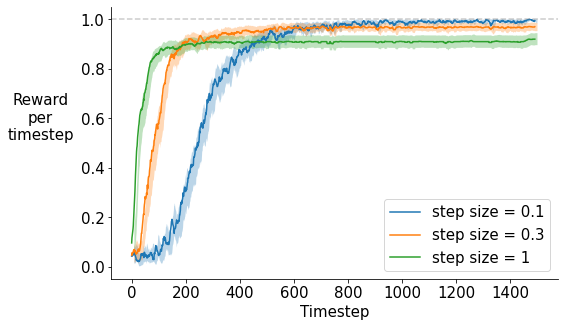

In [ ]:
plot_learning_curves(results_bandit)

The bold line denotes the mean over the 30 runs, and the shaded regions denotes on standard error.

For all the three step sizes tested, the policy improves to pick the optimal action most of the time, but convergence is slow for the larger step sizes (eventually all three configurations converge after ~5k timesteps). Let's now try it again with a baseline — the average reward.

In [ ]:
# This cell will take about 10 seconds to run for 30 runs of 3 step-size configurations

exp_name = "GradientBandit_sweep_baseline"
env = "MultiArmedBandit"
agent = "GradientBanditAgent"

parameters = {
    "exp_parameters": 
    {
        "num_runs": 30,                      
        "num_timesteps": 1500,               
    },
    "env_parameters": 
    {
        "num_actions": 3,
        "rewards": [1,0.7,0],
    },
    "agent_parameters": 
    {  
        "num_actions": 3, 
        "theta_init": [0, 0.4, 4],
        "alpha": [0.1, 0.3, 1],
        "baseline": 'avg_rew',         # the baseline is now a learned estimate of the average reward
        "alpha_r": 0.1,                # step size for the average-reward estimate
    }
}
results_bandit_baseline = run_sweep_bandit(env, agent, parameters, "alpha")

100%|██████████| 30/30 [00:06<00:00,  4.62it/s]


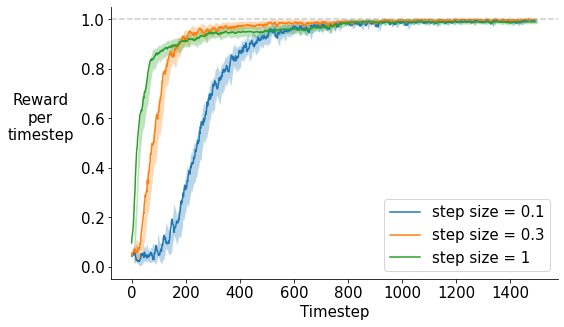

In [ ]:
plot_learning_curves(results_bandit_baseline)

The learning curves look similar to the case without the baseline, but with a baseline, all three stepsize configurations have converged to the optimal policy for picking the action that result in the maximum reward of $1$. 
<!-- The parameter configurations in case of gradient bandit without a baseline can result in convergence to the optimal policy as well, but might take a lot longer than $1500$ steps of agent-environment interactions. -->

For the sake of comparison, let's juxtapose the learning curves for the parameter settings that resulted in the largest returns throughout the learning period both with and without the baseline.

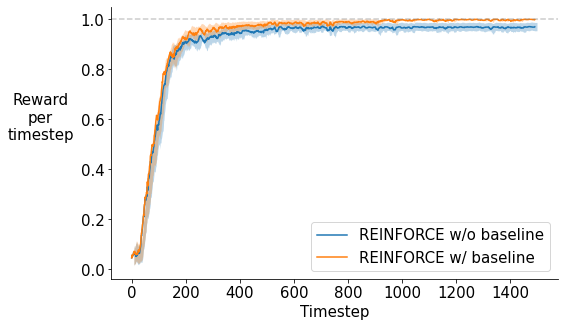

In [ ]:
picked_data = {'REINFORCE w/o baseline': results_bandit['0.3'], 
               'REINFORCE w/ baseline': results_bandit_baseline['0.3']}
plot_learning_curves(picked_data, label_prefix='')

What could really have happened? What role does the baseline play in helping the algorithm converge to the optimal solution faster? 

Let's check the variance of the gradients in both cases. The hypothesis is that a good baseline can result in lower variance of gradients, which could help in faster convergence.

### Checking the variance of the gradients w/ and w/o a baseline
Recall that the true gradient of the objective $J$ is estimated as 
$$ \nabla J(\theta) \approx \frac{1}{N} \sum_i^N \big( R(\tau_i) - b \big) \nabla_\theta \log \pi_\theta(\tau_i), \quad \tau_i \sim \pi_\theta,$$
where $\theta$ denotes the policy parameters, $\pi_\theta$ denotes the resulting parameterized policy, $\tau_i$ denotes the i-th trajectory, $R(\tau_i)$ denotes the return in trajectory $\tau_i$, and $\pi_\theta(\tau_i)$ denotes the probability of trajectory $\tau_i$ occurring.

Clearly, the variance of the random variable $\big( R(\tau_i) - b \big) \nabla_\theta \log \pi_\theta(\tau_i)$ — a sample of the gradient — depends on the baseline $b$. With everything else constant, if the returns for different trajectories vary a lot, then the variance of the whole expression (the gradient) will be large if no baseline is used. But with an appropriate baseline, the variance of the gradient can be reduced. (In fact, we can derive an analytical expression for the minimum-variance baseline. We will use that in Part II of this notebook.)

To ensure a fair comparison of the variance of the gradient with and without a baseline, we shall fix the policy, make multiple rollouts to get multiple samples of the return and the gradient, and then check the variance of the gradient. We shall compare this variance in three scenarios:
- **Towards the beginning of training**: when the policy is suboptimal and picks the action resulting in the least reward with the highest probability. The average-reward estimate at this time is inaccurate. 
- **In the middle of training**: when the learned policy picks every action with roughly the same probability. The average-reward estimate at this time is fairly accurate.
- **Towards the end of training**: when the learned policy is close to optimal. The average-reward estimate at this time is again fairly accurate.

##### Towards the end of training 

In [ ]:
exp_name = "GradientBandit_variance_end"
env = "MultiArmedBandit"
agent = "GradientBanditAgent"

parameters = {
    "exp_parameters": 
    {
        "num_runs": 1,                      
        "num_timesteps": 100,           # we shall perform 100 rollouts 
    },
    "env_parameters": 
    {
        "num_actions": 3,
        "rewards": [1,0.7,0],
    },
    "agent_parameters": 
    {  
        "num_actions": 3,
        "update_every": 200,            # setting this higher than num_timesteps ensures no updates are made before all the rollouts are performed
        "theta_init": [4, 0.4, 0],      # this policy picks the most-rewarding action with high probability
        "alpha": 0.03,                  # since no updates are made, this step size has no effect
        "baseline": 'avg_rew',
        "alpha_r": 0.1,                 # again, since no updates are made, this step size has no effect
        "avg_rew_init": [0, 0.9],       # 0.9 is a good estimate of the average reward for this policy, 0 implies there is no baseline
    }
}
results_bandit_baseline_var = run_sweep_bandit(env, agent, parameters, "avg_rew_init")
print('\n')
print(f"Variance of gradients without baseline:\t {np.var(np.sum(np.absolute(np.array(results_bandit_baseline_var['0'][3][0])), axis=1))}")
print(f"Variance of gradients with baseline:\t {np.var(np.sum(np.absolute(np.array(results_bandit_baseline_var['0.9'][3][0])), axis=1))}")

100%|██████████| 1/1 [00:00<00:00, 73.56it/s]



Variance of gradients without baseline:	 0.06269845424860207
Variance of gradients with baseline:	 0.035689975188755094


In this scenario, the variance of the gradients is lower when the baseline is used.

##### In the middle of training

In [ ]:
exp_name = "GradientBandit_variance_middle"
env = "MultiArmedBandit"
agent = "GradientBanditAgent"

parameters = {
    "exp_parameters": 
    {
        "num_runs": 1,                      
        "num_timesteps": 100,           # again, we shall perform 100 rollouts 
    },
    "env_parameters": 
    {
        "num_actions": 3,
        "rewards": [1,0.7,0],
    },
    "agent_parameters": 
    {  
        "num_actions": 3,
        "update_every": 200,            
        "theta_init": [1, 1, 1],        # this policy picks all actions with equal probability
        "alpha": 0.03,                  # again, since no updates are made, this step size has no effect
        "baseline": 'avg_rew',
        "alpha_r": 0.1,                 # again, since no updates are made, this step size has no effect
        "avg_rew_init": [0, 0.6],       # 0.6 is a good estimate of the average reward for this policy, 0 implies there is no baseline
    }
}
results_bandit_baseline_var = run_sweep_bandit(env, agent, parameters, "avg_rew_init")
print('\n')
print(f"Variance of gradients without baseline:\t {np.var(np.sum(np.absolute(np.array(results_bandit_baseline_var['0'][3][0])), axis=1))}")
print(f"Variance of gradients with baseline:\t {np.var(np.sum(np.absolute(np.array(results_bandit_baseline_var['0.6'][3][0])), axis=1))}")

100%|██████████| 1/1 [00:00<00:00, 63.60it/s]



Variance of gradients without baseline:	 0.2967751111111111
Variance of gradients with baseline:	 0.07158044444444445


Again, when the estimate of the baseline is fairly accurate,  the variance of the gradients is lower when the baseline is used.

##### Towards the beginning of training

In [ ]:
exp_name = "GradientBandit_variance_start"
env = "MultiArmedBandit"
agent = "GradientBanditAgent"

parameters = {
    "exp_parameters": 
    {
        "num_runs": 1,                      
        "num_timesteps": 100,           # again, we shall perform 100 rollouts 
    },
    "env_parameters": 
    {
        "num_actions": 3,
        "rewards": [1,0.7,0],
    },
    "agent_parameters": 
    {  
        "num_actions": 3,
        "update_every": 200,            
        "theta_init": [0, 0.4, 4],      # this policy picks the least-rewarding action with high probability
        "alpha": 0.03,                  # again, since no updates are made, this step size has no effect
        "baseline": 'avg_rew',
        "alpha_r": 0.1,                 # again, since no updates are made, this step size has no effect
        "avg_rew_init": [0, -0.1],      # -0.1 is a bad estimate of the average reward for this policy, 0 implies there is no baseline
    }
}
results_bandit_baseline_var = run_sweep_bandit(env, agent, parameters, "avg_rew_init")
print('\n')
print(f"Variance of gradients without baseline:\t {np.var(np.sum(np.absolute(np.array(results_bandit_baseline_var['0'][3][0])), axis=1))}")
print(f"Variance of gradients with baseline:\t {np.var(np.sum(np.absolute(np.array(results_bandit_baseline_var['-0.1'][3][0])), axis=1))}")

100%|██████████| 1/1 [00:00<00:00, 66.45it/s]



Variance of gradients without baseline:	 0.10746353926776395
Variance of gradients with baseline:	 0.13540260396238396


Not all baselines result in a reduction in variance of gradients! For instance, in this case, the estimate of the average reward was inaccurate at the beginning of training, which ended up increasing at variance at this point in time. But overall, there can be a reduction in variance of the gradients as the estimate gets better.


Let's move on to Part II, where we find that baselines can impact the optimization process beyond variance reduction. In particular, we shall see that the entropy of the learned policies can have significant differences even when the variance of the baselines is the same.

## Part II/II: Baselines can affect stochasticity of learned policies

In the previous experiment, we tried Gradient Bandit with different baselines and observed the difference in the variance of updates and its indirect effect on the learning curves. One way to control for the effect of variance in updates due to different baselines is to choose different baselines having the same variance. How can we obtain different baselines with the same variance? 

The analytical expression for the baseline that results in the minimum variance of gradients is given by
$$ b^* = \frac{\mathbb{E} \big[ R(\tau)\ \Vert  \nabla \log \pi(\tau) \Vert^2_2 \big]}{\mathbb{E} \big[ \Vert  \nabla \log \pi(\tau) \Vert^2_2 \big]}.$$ 
(see Chung et al. 2020; Peters and Schaal 2008)

Since variance is a quadratic function of the baseline, adding and subtracting the same constant to $b^*$ results in the same variance. This means that any differences in the behaviour of two baselines such as $b^* - 1$ and $b^* + 1$ cannot be attributed to a difference in variance of updates.

Computing the minimium-variance baseline $b^*$ analytically is hard for most problems, but is quite straightforward for bandit problems. 

### Gradient Bandit algorithm with variants of the minimum-variance baseline

Now let's try baselines of the form $b^*$, $b^*+1$, $b^*-1$ and check the entropy of the learned policies.

In [ ]:
# This cell will take about 20 seconds to run for 15 runs of 3 baselines

exp_name = "GradientBandit_baseline_sweep"
env = "MultiArmedBandit"
agent = "GradientBanditAgent"

parameters = {
    "exp_parameters": 
    {
        "num_runs": 15,                      
        "num_timesteps": 2000,               
    },
    "env_parameters": 
    {
        "num_actions": 3,
        "rewards": [1, 0.7, 0],
    },
    "agent_parameters": 
    {  
        "num_actions": 3, 
        "theta_init": [0, 0.4, 4],        # initial policy picks the least-rewarding action with high probability 
        "alpha": 0.05,
        "baseline": 'min_var',
        "baseline_offset": [-1, 0, 1],
        "env_rewards": [1, 0.7, 0]
    }
}
results_bandit_baseline_sweep = run_sweep_bandit(env, agent, parameters, "baseline_offset")

100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


Let's plot some learning curves to check the learning progress with the three baselines.

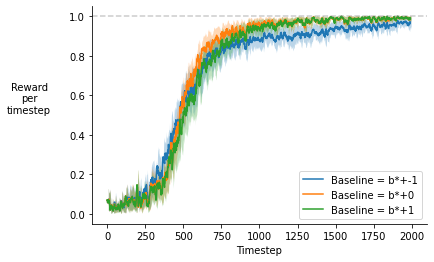

In [ ]:
plot_learning_curves(results_bandit_baseline_sweep, label_prefix='Baseline = b*+')

Great, with all the three baselines, the algorithm has almost converged to the optimal policy of picking the action that leads to the maximum reward (in this case, $1$).

#### Visualization code

To visualize the evolution of the learned policies, we'll need an additional library.

In [ ]:
!pip install python-ternary
import ternary

def plot_trajectories(trajectory_data, title):

    num_runs = trajectory_data.shape[0]

    figure, tax = ternary.figure(scale=1.0)
    tax.boundary()
    tax.get_axes().axis('off')
    tax.gridlines(multiple=0.2, color="black")
    tax.set_title(title+'\n', fontsize=20)
    tax.right_corner_label("R = 1.0")
    tax.top_corner_label("R = 0.7")
    tax.left_corner_label("R = 0.0")
    for run in range(num_runs):
        points = trajectory_data[run]
        tax.plot_colored_trajectory(points, linewidth=2.0)
        tax.scatter([points[0]], marker='o', color='black', s=64)
        tax.scatter([points[-1]], marker='o', color='red', s=64, edgecolors='red')
    tax.show()

def plot_baseline_stats(data):
    data_max = np.max(data, axis=0) 
    data_min = np.min(data, axis=0) 
    data = np.mean(data, axis=0)
    plt.plot(data)
    plt.plot(data_max, label='max')
    plt.plot(data_min, label='min')

#### Visualizing the evolution of the learned policies

Let us first visualize the evolution of the policy for 15 independent runs when the minimium-variance baseline $b^*$ is used.  

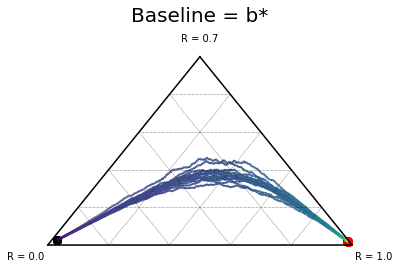

In [ ]:
plot_trajectories(results_bandit_baseline_sweep['0'][1], title='Baseline = b*')

This figure shows a policy simplex with the three deterministic policies at each of three corners. The black circle on the left denotes the starting policy (which in this case was initially biased to pick the least rewarding action that results in a deterministic reward of $0$). The red circles denote the learned policy at the end of training for each of independent runs of the algorithm. The curves denote the evolution of the policy; the colors denote the increment of time from purple to green to yellow.

In case of the baseline $b^*$, we see that in all the independent runs, the policies started near-deterministically from the suboptimal arm of reward $0$ and ended up at the optimal arm of reward $1$. All the policies travel through the center of the simplex, which denotes a region of high entropy/stochasticity in the policy.

Let us now check out the evolution of the policies for the two baselines $b^*-1$ and $b^*+1$, which have an equal variance of updates.

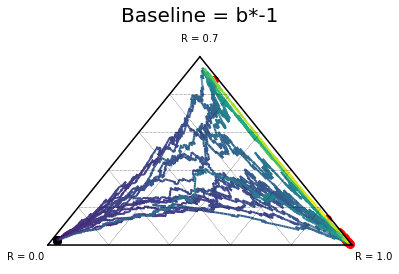

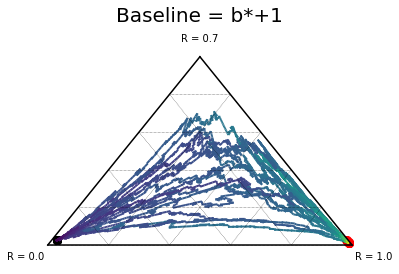

In [ ]:
plot_trajectories(results_bandit_baseline_sweep['-1'][1], title='Baseline = b*-1')
plot_trajectories(results_bandit_baseline_sweep['1'][1], title='Baseline = b*+1')

Something interesting happened here. First of all, the policy-paths were more spread out, which indicates that there was greater variation in how the policies evolved in the different runs.

More interestingly, in case of the baseline $b^*-1$, some of the policy-paths went close to the sub-optimal solution of deterministically picking the arm with reward $0.7$ (near the top of the simplex) before eventually ending up at the optimal solution. On the other hand, with the baseline $b^*+1$, the policy-paths all ended up at the optimal policy without venturing close to the deterministic sub-optimal solution.

<br>

It seems that that different baselines result in different profiles of the evolution of the policies using a policy-gradient method. How can this be explained? Note that both the baselines result in identical variance of the updates, so that cannot explain the difference in behaviours. 

The update rule sheds some light: $\Delta \mathbf{\theta} \propto (R - b) (\mathbb{1}_a - \mathbf{\pi_\theta})$, where $\Delta \mathbf{\theta}$ is the change in the policy parameters $\mathbf{\theta}$, $R$ is the instantaneous reward, $b$ is the baseline, $\mathbb{1}_a$ is a one-hot vector with $1$ corresponding to the action $a$ taken and $0$ otherwise, and $\pi_\theta$ is the policy. 
- When the baseline is a large negative number — smaller than the smallest reward — then all actions seem rewarding to the agent (the term $R-b$ is positive for all actions). This implies that the probability of picking the currently-chosen action always increases. This increases the tendency of the policy to become more deterministic, sometimes resulting in a sub-optimal deterministic policy (as observed above for baseline $b^*-1$). 
- When the baseline is a large positive number — larger than the largest reward — then all actions seem bad to the agent (the term $R-b$ is always negative for all actions). This implies that the probability of picking the currently-chosen action always decreases. This increases the tendecy of the policy to become more stochastic — which encourages exploration — helping the agent stay away from (sub-optimal) local maximas (as observed for baseline $b^*+1$).

## Takeaways

1. Baselines can affect the variance of gradients in policy-gradient methods. Typically, baselines are chosen to reduce the variance of gradients, which can speed up learning.
2. Apart from the variance, baselines can affect the optimization dynamics. For instance, the entropy profile of the policy during learning can have significant differences even when the baselines have identical variance.

The optimization process for policy-gradient methods holds many mysteries and is ripe for further research!

<br>

## Try out your own experiments!

- Following Chung et al. (2020), we've tried out offsets of $-1$ and $+1$, but you can try larger or smaller offset by setting the parameter `"baseline_offset"` in the experiment configuration.  
- We've currently implemented the average-reward baseline and the minimum-variance baseline. You can try some others by adding to the `GradientBanditAgent` class.
- You can even try extending the algorithm and experiments beyond bandits to the full-RL setting :) 

## References

- Sutton, R. S., Barto, A. G. (2018). _Reinforcement Learning: An Introduction._ MIT Press.
- Chung, W., Thomas, V., Machado, M. C., & Roux, N. L. (2020). Beyond variance reduction: Understanding the true impact of baselines on policy optimization. _arXiv_, 2008.13773.
- Peters, J., & Schaal, S. (2008). Reinforcement learning of motor skills with policy gradients. _Neural Networks,_ 21(4), 682–697.

## Acknowledgements

We would like to thank Wesley Chung and Valentin Thomas for insightful discussions on Part II of the notebook, and Yi Wan for reviewing the notebook. 